# **Cryptocurrency prediction**


**Long Short-Term Memory RNN Model**

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Activation

In [0]:
# Calculate  Symmetric Mean Absolute Percentage Error
#SMAPE is not currently supported in Scikit-learn as a loss function I, therefore, had first to create this function on my own.
def smape(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

<img src="smape.png">

*Create train and test data*

In [0]:
#Historical prices of Ethereum one year long from Yahoo Finance
eth = pd.read_csv("ETH-USD_2.csv")
 #For normaliazation
scaler = MinMaxScaler()

eth = eth.set_index("Date")[['Close']]
eth = eth.set_index(pd.to_datetime(eth.index))
eth = pd.DataFrame(scaler.fit_transform(eth), columns=eth.columns, index=eth.index)

*Function in order to Split the Data*

In [0]:
def split_sequence(seq,n_input,n_output):
  X, y = list(), list()

  for i in range(len(seq)):
	  # find the end of this pattern
    end = i + n_input
    out_end = end + n_output
		# check if we are beyond the sequence
    if out_end > len(seq):
      break
		# gather input and output parts of the pattern
    seq_x, seq_y = seq[i:end], seq[end:out_end]
    X.append(seq_x)
    y.append(seq_y)

  return np.array(X), np.array(y)

*Create train and test data*

In [0]:
#Looking 40 days past to predict 3 days in the future
features = 1 
future = 3
past = 40

X,y=split_sequence(list(eth.Close),past,future)
X = X.reshape((X.shape[0], X.shape[1], features))
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,test_size=0.2)

*Build the structure of a LSTM Recurrent Neural Net which is ideal for Time-Series Prediction*

In [0]:
#Network Structure
model=Sequential()
model.add(LSTM(1024,input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(future,activation='tanh'))
#Forward pass
model.compile(loss='mse',optimizer='adamax')
#Backpropagation
model.fit(X_train,y_train,epochs=100,batch_size=32,verbose=0)
y_pred=model.predict(X_test,batch_size=32)

*Visualize the result of the predicted(Red) and the actual(Blue) prices*

(65, 3)


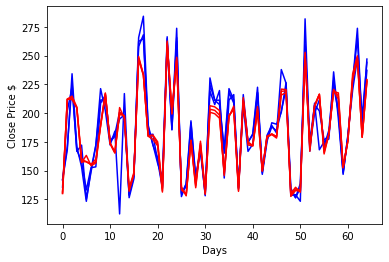

In [163]:
y_test_inverse = scaler.inverse_transform(y_test)
y_pred_inverse = scaler.inverse_transform(y_pred)
x=list()
for i in range(1,66):
  x.append(i)
x=np.array(x)
print(y_test_inverse.shape)

plt.plot(y_test_inverse, label="Actual Price", color='blue')
plt.plot(y_pred_inverse, label="Predicted Price", color='red')
plt.xlabel("Days")
plt.ylabel("Close Price $")
#plt.legend(loc="best", numpoints=1)
plt.show()

Some Metrics of how our Model (LSTM) performed

In [164]:
from sklearn.metrics import mean_squared_error

mse_error = mean_squared_error(y_test,y_pred)
print('Mean Squared Error:',mse_error)

Mean Squared Error: 0.004764410308690748


**Predicting the price of Ethereum for next 5 days using all the previous days of the Dataset**

In [0]:
eth2 = pd.read_csv("ETH-USD_2.csv")
#Remove Unneccessary information
eth2.drop(['Date','Open','High','Low','Adj Close','Volume'], 1, inplace=True)
future_days = 5
#Create another column (the target or dependent variable) shifted 'future days' units up
eth2['Prediction'] = eth2[['Close']].shift(-future_days)

*Create the independent Dataset*

In [0]:
#This is the set that contains the features to make the future predictions with

X=np.array(eth2.drop(['Prediction'], 1))
X = X[:len(eth2)- future_days]

*Create the dependent Data*

In [0]:
#This will be the data set that contains our target, that’s the data that we are trying to predict

y=np.array(eth2['Prediction'])
#Remove Last 5 Days
y = y[:-future_days]

*Spilt Data*

In [0]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

*Create a variable called prediction_days_array and set it equal to the last 5 rows of the original data set from the price column.*

In [185]:
future_days_array=np.array(eth2.drop(['Prediction'],1))[-future_days:]
print(future_days_array)

[[241.93132 ]
 [245.167252]
 [246.309906]
 [244.911453]
 [243.608917]]


Create the Support Vector Regression model using the radial basis function (rbf), and train the model.

In [170]:
from sklearn.svm import SVR

rbf=SVR(kernel='rbf', C=1e3, gamma=0.00001)
rbf.fit(x_train, y_train)

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1e-05,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

*Visualazation of rbf SVR*

0.748634699650756


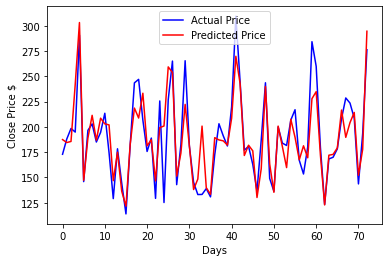

In [171]:
rbf_accuracy=rbf.score(x_test, y_test)
print(rbf_accuracy)
y_pred=rbf.predict(x_test)

plt.plot(y_test, label="Actual Price", color="blue")
plt.plot(y_pred, label="Predicted Price", color="red")
plt.xlabel("Days")
plt.ylabel("Close Price $")
plt.legend(loc="best")
plt.show()

*Test the models accuracy*

In [172]:
y_pred = rbf.predict(x_test)

mse_error = mean_squared_error(y_test,y_pred)
print('Mean Squared Error:',mse_error)
print('Symmetric Mean Absolute Percentage Error:',smape(y_test, y_pred))

Mean Squared Error: 468.4078971918769
Symmetric Mean Absolute Percentage Error: 7.654683608582858


*Create the XGB Regression model*

In [178]:
from xgboost import XGBRegressor

xg = XGBRegressor()
xg.fit(x_train, y_train)

[17:15:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

Test the models accuracy and visualiaze the results



0.7904785980845315


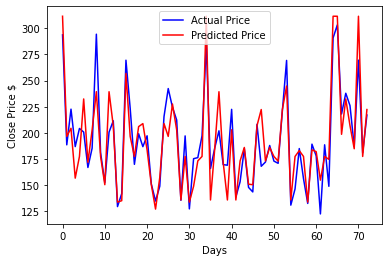

In [179]:
xg_accuracy=xg.score(x_test, y_test)
print(xg_accuracy)
y_pred=xg.predict(x_test)

plt.plot(y_test, label="Actual Price", color='blue')
plt.plot(y_pred, label="Predicted Price", color='red')
plt.xlabel("Days")
plt.ylabel("Close Price $")
plt.legend(loc="best")
plt.show()

*Some Metrics of how XGB Regression performed*

In [180]:
y_pred = xg.predict(x_test)

mse_error = mean_squared_error(y_test,y_pred)
print('Mean Squared Error:',mse_error)
print('Symmetric Mean Absolute Percentage Error:',smape(y_test, y_pred))

Mean Squared Error: 393.7037196984058
Symmetric Mean Absolute Percentage Error: 7.393996875049094


*Create the Random Forrest Regressor model*

In [186]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

*Visualiaze the results*

0.6238866462710795


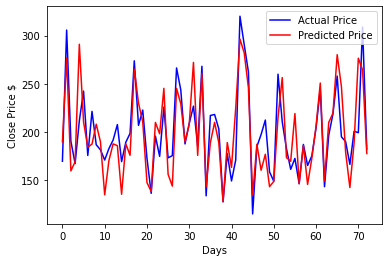

In [187]:
rf_accuracy=rf.score(x_test, y_test)
print(rf_accuracy)
y_pred=rf.predict(x_test)

plt.plot(y_test, label="Actual Price", color='blue')
plt.plot(y_pred, label="Predicted Price", color='red')
plt.xlabel("Days")
plt.ylabel("Close Price $")
plt.legend(loc="best")
plt.show()

*Some Metrics of how Random Forest Regressor performed*

In [188]:
y_pred = rf.predict(x_test)

mse_error = mean_squared_error(y_test,y_pred)
print('Mean Squared Error:',mse_error)
print('Symmetric Mean Absolute Percentage Error:',smape(y_test, y_pred))

Mean Squared Error: 675.2690024959884
Symmetric Mean Absolute Percentage Error: 9.69748669117461


**ARIMA (AutoRegressive Integrated Moving Average) Model**

In [0]:
#Arima
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [190]:
df = pd.read_csv('ETH-USD_2.csv')
df.head(7)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-06-10,232.830139,247.662170,229.341766,247.520126,247.520126,8141159847
1,2019-06-11,247.862122,248.662582,239.825348,245.781830,245.781830,7382269700
2,2019-06-12,245.925491,261.017578,244.491318,260.903290,260.903290,8645598617
3,2019-06-13,260.913513,262.163116,255.596283,256.168793,256.168793,8442077836
4,2019-06-14,256.179657,265.371399,254.147430,264.087463,264.087463,8676891266
5,2019-06-15,263.934143,271.505585,262.121216,269.019318,269.019318,8126853943
6,2019-06-16,268.901154,278.143188,265.535339,269.223206,269.223206,9676746452


Text(0.5, 1.0, 'Etherium Autocorrelation plot')

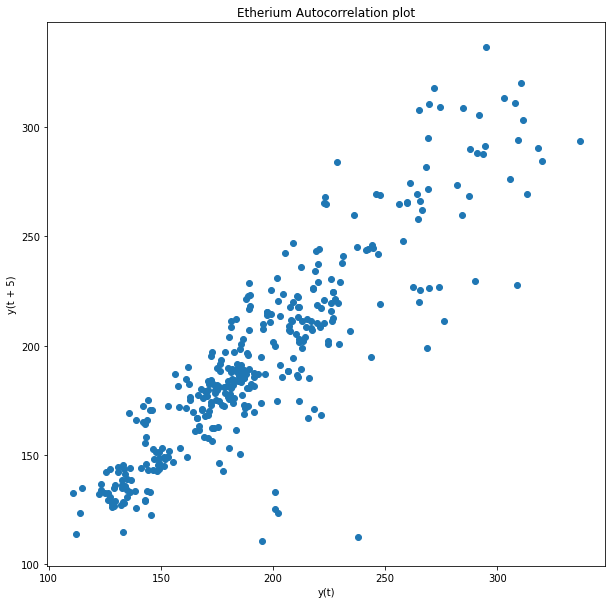

In [191]:
# We analysed the autocorrelation plot of the “Close” feature with respect to a fixed lag of 5. The results shown confirmed the ARIMA would have been a good model to be applied to this type of data.

plt.figure(figsize=(10,10))
lag_plot(df['Close'], lag=5)
plt.title('Etherium Autocorrelation plot')

*Create test and train data and plot them*

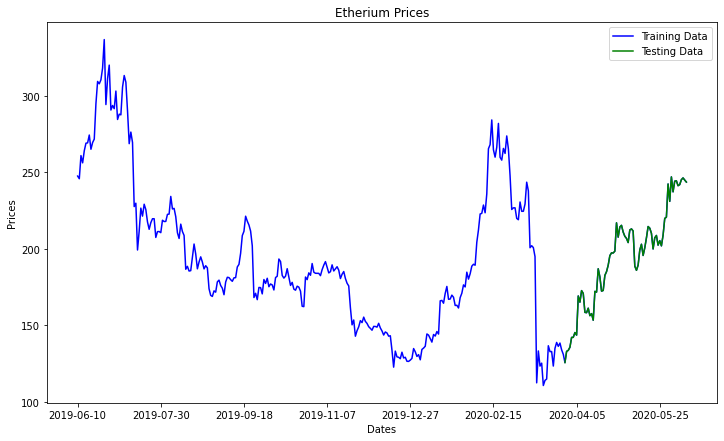

In [192]:
train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]
plt.figure(figsize=(12,7))
plt.title('Etherium Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df['Close'], 'blue', label='Training Data')
plt.plot(test_data['Close'], 'green', label='Testing Data')
plt.xticks(np.arange(0,400, 50), df['Date'][0:400:50])
plt.legend(loc="best")

Create the ARIMA model to be used for this implementation.Decide to set in this case p=5, d=1 and q=0 as the ARIMA parameters.


---


*   p = number of lag observation
*   d = degree of differencing
*   q = the size of moving average window






In [193]:
train_ar = train_data['Close'].values
test_ar = test_data['Close'].values
history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: ',error)
error2 = smape(test_ar, predictions)
print('Testing Symmetric Mean Absolute squared error percentage', error2)

<class 'list'>
Testing Mean Squared Error:  65.02266893160248
Testing Symmetric Mean Absolute squared error percentage 19.061533596453813


*Plot the training, test and predicted prices against time*

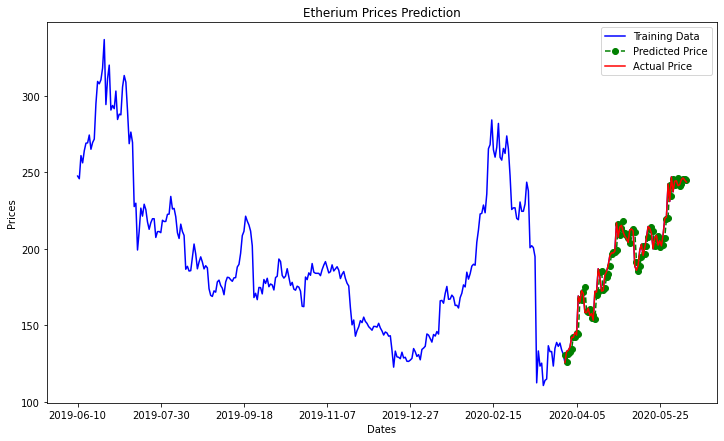

In [194]:
plt.figure(figsize=(12,7))
plt.plot(df['Close'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Actual Price')
plt.title('Etherium Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(0,400,50), df['Date'][0:400:50])
plt.legend()

*Zoomed version of the previous plot for predicted and actual prices*

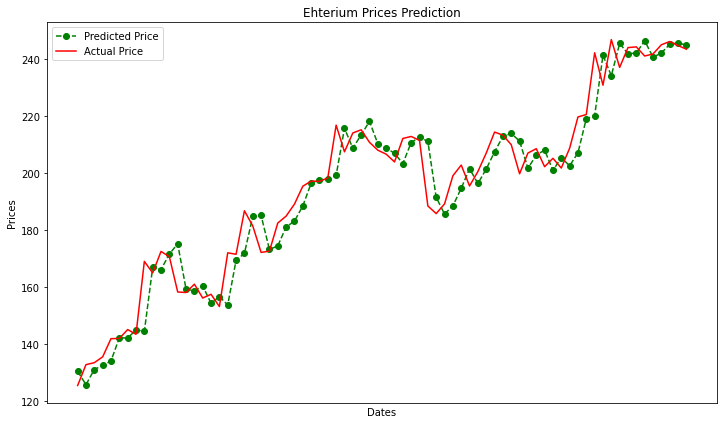

In [195]:
plt.figure(figsize=(12,7))
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Actual Price')
plt.legend()
plt.title('Ehterium Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(20,40,100), df['Date'][20:40:100])
plt.legend()

**AutoML with H2O Framework**

In [196]:
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install h2o

     |████████████████████████████████| 128.3MB 110kB/s 
  Created wheel for h2o: filename=h2o-3.30.0.4-py2.py3-none-any.whl size=128397038 sha256=855466e087b05fc6b141da229924466dd431fcc69aeb7d4cf66ccc19cf008a87
  Stored in directory: /root/.cache/pip/wheels/ad/bd/cc/0a8c7dffc4772df0bbfae4c1c7a9d64525fcd3ada9694dd8c3
Successfully built h2o


In [0]:
eth = pd.read_csv('ETH-USD_2.csv')

*Preproccess Data*

In [198]:
lag_labels = ['Open','Close','High','Low','Volume']
for label in lag_labels:
  for i in range(3):
    eth[label+'_lag_'+str(i+1)] = df[label].shift(-(i+1))
eth.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Open_lag_1,Open_lag_2,Open_lag_3,Close_lag_1,Close_lag_2,Close_lag_3,High_lag_1,High_lag_2,High_lag_3,Low_lag_1,Low_lag_2,Low_lag_3,Volume_lag_1,Volume_lag_2,Volume_lag_3
0,2019-06-10,232.830139,247.662170,229.341766,247.520126,247.520126,8141159847,247.862122,245.925491,260.913513,245.781830,260.903290,256.168793,248.662582,261.017578,262.163116,239.825348,244.491318,255.596283,7.382270e+09,8.645599e+09,8.442078e+09
1,2019-06-11,247.862122,248.662582,239.825348,245.781830,245.781830,7382269700,245.925491,260.913513,256.179657,260.903290,256.168793,264.087463,261.017578,262.163116,265.371399,244.491318,255.596283,254.147430,8.645599e+09,8.442078e+09,8.676891e+09
2,2019-06-12,245.925491,261.017578,244.491318,260.903290,260.903290,8645598617,260.913513,256.179657,263.934143,256.168793,264.087463,269.019318,262.163116,265.371399,271.505585,255.596283,254.147430,262.121216,8.442078e+09,8.676891e+09,8.126854e+09
3,2019-06-13,260.913513,262.163116,255.596283,256.168793,256.168793,8442077836,256.179657,263.934143,268.901154,264.087463,269.019318,269.223206,265.371399,271.505585,278.143188,254.147430,262.121216,265.535339,8.676891e+09,8.126854e+09,9.676746e+09
4,2019-06-14,256.179657,265.371399,254.147430,264.087463,264.087463,8676891266,263.934143,268.901154,269.090576,269.019318,269.223206,274.351105,271.505585,278.143188,275.442566,262.121216,265.535339,268.353790,8.126854e+09,9.676746e+09,6.009796e+09


In [0]:
eth.to_csv('ETH-USD_2_lags.csv')

In [200]:
import h2o
from h2o.automl import H2OAutoML

h2o.init(max_mem_size='16G')

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.7" 2020-04-14; OpenJDK Runtime Environment (build 11.0.7+10-post-Ubuntu-2ubuntu218.04); OpenJDK 64-Bit Server VM (build 11.0.7+10-post-Ubuntu-2ubuntu218.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpdaz102df
  JVM stdout: /tmp/tmpdaz102df/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpdaz102df/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.4
H2O_cluster_version_age:,9 days
H2O_cluster_name:,H2O_from_python_unknownUser_y4oovv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,16 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [201]:
eth_lags = h2o.import_file('ETH-USD_2_lags.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [202]:
eth_lags.head()

C1,Date,Open,High,Low,Close,Adj Close,Volume,Open_lag_1,Open_lag_2,Open_lag_3,Close_lag_1,Close_lag_2,Close_lag_3,High_lag_1,High_lag_2,High_lag_3,Low_lag_1,Low_lag_2,Low_lag_3,Volume_lag_1,Volume_lag_2,Volume_lag_3
0,2019-06-10 00:00:00,232.83,247.662,229.342,247.52,247.52,8.14116e+09,247.862,245.925,260.914,245.782,260.903,256.169,248.663,261.018,262.163,239.825,244.491,255.596,7.38227e+09,8.6456e+09,8.44208e+09
1,2019-06-11 00:00:00,247.862,248.663,239.825,245.782,245.782,7.38227e+09,245.925,260.914,256.18,260.903,256.169,264.087,261.018,262.163,265.371,244.491,255.596,254.147,8.6456e+09,8.44208e+09,8.67689e+09
2,2019-06-12 00:00:00,245.925,261.018,244.491,260.903,260.903,8.6456e+09,260.914,256.18,263.934,256.169,264.087,269.019,262.163,265.371,271.506,255.596,254.147,262.121,8.44208e+09,8.67689e+09,8.12685e+09
3,2019-06-13 00:00:00,260.914,262.163,255.596,256.169,256.169,8.44208e+09,256.18,263.934,268.901,264.087,269.019,269.223,265.371,271.506,278.143,254.147,262.121,265.535,8.67689e+09,8.12685e+09,9.67675e+09
4,2019-06-14 00:00:00,256.18,265.371,254.147,264.087,264.087,8.67689e+09,263.934,268.901,269.091,269.019,269.223,274.351,271.506,278.143,275.443,262.121,265.535,268.354,8.12685e+09,9.67675e+09,6.0098e+09
5,2019-06-15 00:00:00,263.934,271.506,262.121,269.019,269.019,8.12685e+09,268.901,269.091,274.32,269.223,274.351,265.052,278.143,275.443,274.32,265.535,268.354,263.144,9.67675e+09,6.0098e+09,6.20524e+09
6,2019-06-16 00:00:00,268.901,278.143,265.535,269.223,269.223,9.67675e+09,269.091,274.32,265.057,274.351,265.052,269.432,275.443,274.32,270.333,268.354,263.144,264.755,6.0098e+09,6.20524e+09,5.51651e+09
7,2019-06-17 00:00:00,269.091,275.443,268.354,274.351,274.351,6.0098e+09,274.32,265.057,269.408,265.052,269.432,271.695,274.32,270.333,274.074,263.144,264.755,265.5,6.20524e+09,5.51651e+09,6.40898e+09
8,2019-06-18 00:00:00,274.32,274.32,263.144,265.052,265.052,6.20524e+09,265.057,269.408,271.743,269.432,271.695,294.91,270.333,274.074,295.303,264.755,265.5,271.743,5.51651e+09,6.40898e+09,9.33169e+09
9,2019-06-19 00:00:00,265.057,270.333,264.755,269.432,269.432,5.51651e+09,269.408,271.743,295.115,271.695,294.91,309.38,274.074,295.303,315.19,265.5,271.743,294.728,6.40898e+09,9.33169e+09,1.06137e+10


In [0]:
splits = eth_lags.split_frame(ratios=[0.8],seed=1)
train = splits[0]
test = splits[1]

In [204]:
eth_lags.columns

['C1',
 'Date',
 'Open',
 'High',
 'Low',
 'Close',
 'Adj Close',
 'Volume',
 'Open_lag_1',
 'Open_lag_2',
 'Open_lag_3',
 'Close_lag_1',
 'Close_lag_2',
 'Close_lag_3',
 'High_lag_1',
 'High_lag_2',
 'High_lag_3',
 'Low_lag_1',
 'Low_lag_2',
 'Low_lag_3',
 'Volume_lag_1',
 'Volume_lag_2',
 'Volume_lag_3']

In [0]:
y = "Close" 
x = ['Open_lag_1',
 'Open_lag_2',
 'Open_lag_3',
 'Close_lag_1',
 'Close_lag_2',
 'Close_lag_3',
 'High_lag_1',
 'High_lag_2',
 'High_lag_3',
 'Low_lag_1',
 'Low_lag_2',
 'Low_lag_3',
 'Volume_lag_1',
 'Volume_lag_2',
 'Volume_lag_3']

*Use AutoML to select the best 10 Models*

In [206]:
aml = H2OAutoML(max_runtime_secs=120, seed=1)
aml.train(x=x,y=y, training_frame=train, validation_frame = test)

AutoML progress: |
17:18:47.238: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

████████████████████████████████████████████████████████| 100%


In [207]:
lb = aml.leaderboard
lb.head()

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GLM_1_AutoML_20200610_171847,10.9233,3.30504,10.9233,1.38726,0.015261
StackedEnsemble_BestOfFamily_AutoML_20200610_171847,12.1208,3.4815,12.1208,1.25456,0.0164156
XGBoost_grid__1_AutoML_20200610_171847_model_3,14.111,3.75646,14.111,1.65599,0.0180494
StackedEnsemble_AllModels_AutoML_20200610_171847,15.9546,3.99432,15.9546,1.67304,0.019146
GBM_grid__1_AutoML_20200610_171847_model_8,17.3474,4.16502,17.3474,1.10406,0.0203812
GBM_4_AutoML_20200610_171847,22.1774,4.70929,22.1774,1.80024,0.0223491
XGBoost_3_AutoML_20200610_171847,23.9429,4.89315,23.9429,3.02245,0.0246573
GBM_1_AutoML_20200610_171847,24.1058,4.90977,24.1058,2.36094,0.0246286
GBM_2_AutoML_20200610_171847,25.0135,5.00135,25.0135,2.11884,0.0237768
GBM_3_AutoML_20200610_171847,26.6795,5.16522,26.6795,2.30573,0.0246703


*Use the best model for prediction*

In [208]:
aml.leader

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_1_AutoML_20200610_171847


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gaussian,identity,Ridge ( lambda = 0.007543 ),"nlambda = 30, lambda.max = 4684.2, lambda.min = 0.007543, lambda.1...",15,15,30,automl_training_py_3_sid_a593




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 9.468492698791286
RMSE: 3.07709159740026
MAE: 1.1666470765211834
RMSLE: 0.014161503027481556
R^2: 0.9957282980901725
Mean Residual Deviance: 9.468492698791286
Null degrees of freedom: 295
Residual degrees of freedom: 280
Null deviance: 656102.3915068598
Residual deviance: 2802.6738388422204
AIC: 1539.4106513273298

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 1.981611475697604
RMSE: 1.4076972244405415
MAE: 1.0350063685517374
RMSLE: 0.008750493028092478
R^2: 0.9986148438058791
Mean Residual Deviance: 1.981611475697604
Null degrees of freedom: 70
Residual degrees of freedom: 55
Null deviance: 112964.22573041392
Residual deviance: 140.6944147745299
AIC: 284.0469094266061

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 10.923321178982233
RMSE: 3.3050448074091574
MAE: 1.3872564781194219
RMSLE: 0.015261000897509442
R^2: 0.9950719535382992
Mean Residual Deviance: 10.9

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,1.1203345,0.4083076,1.7845231,0.8983073,0.72243863,1.1907139,1.0056897
1,mean_residual_deviance,9.461469,16.680466,39.23941,1.609441,0.8822297,3.763154,1.8131095
2,mse,9.461469,16.680466,39.23941,1.609441,0.8822297,3.763154,1.8131095
3,null_deviance,131283.5,6478.0347,137208.8,131943.14,126373.125,123138.63,137753.81
4,r2,0.99581945,0.007287109,0.9828181,0.9992803,0.999588,0.9981874,0.99922335
5,residual_deviance,566.0745,1001.66064,2354.3647,94.95702,52.05155,222.0261,106.973465
6,rmse,2.3516896,2.216705,6.264137,1.2686374,0.93927085,1.9398851,1.3465176
7,rmsle,0.010837621,0.010062003,0.028673287,0.006438195,0.0043902826,0.008214691,0.0064716507



Scoring History: 


,,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test,deviance_xval,deviance_se
0,,2020-06-10 17:19:00,0.000 sec,1,.47E4,16,2206.065267,1583.310975,2208.993826,45.599131
1,,2020-06-10 17:19:00,0.001 sec,2,.29E4,16,2199.699630,1578.620834,2203.895481,45.581577
2,,2020-06-10 17:19:00,0.003 sec,3,.18E4,16,2189.511206,1571.114550,2195.727940,45.553194
3,,2020-06-10 17:19:00,0.005 sec,4,.11E4,16,2173.260289,1559.143026,2182.672840,45.507713
4,,2020-06-10 17:19:00,0.008 sec,5,.7E3,16,2147.487501,1540.160220,2161.906119,45.434779
5,,2020-06-10 17:19:00,0.009 sec,6,.43E3,16,2106.990286,1510.340250,2129.116063,45.318101
6,,2020-06-10 17:19:00,0.011 sec,7,.27E3,16,2044.263433,1464.171355,2077.941188,45.132161
7,,2020-06-10 17:19:00,0.012 sec,8,.17E3,16,1949.289280,1394.315840,1999.527684,44.837528
8,,2020-06-10 17:19:00,0.013 sec,9,.1E3,16,1810.411550,1292.281555,1882.761205,44.374636
9,,2020-06-10 17:19:00,0.015 sec,10,.64E2,16,1617.665576,1150.921253,1716.263195,43.656703



See the whole table with table.as_data_frame()


In [209]:
pred_H2OStackedEnsembleEstimator = aml.leader.predict(test)
pred_H2OStackedEnsembleEstimator = pred_H2OStackedEnsembleEstimator.as_data_frame()['predict'].tolist()

glm prediction progress: |████████████████████████████████████████████████| 100%


In [0]:
eth = pd.read_csv('ETH-USD_2.csv')
true_close = eth['Close'].tolist()[:len(pred_H2OStackedEnsembleEstimator)][::-1]
true_vs_pred = pd.DataFrame({'True Close':true_close,'Predicted Close':pred_H2OStackedEnsembleEstimator})

In [0]:
true_vs_pred.to_csv('true_vs_pred_automl.csv')

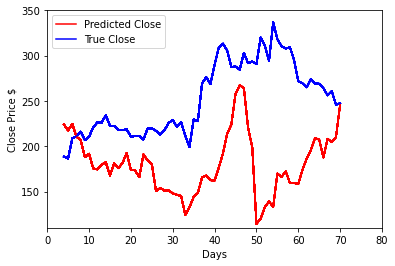

In [212]:
%matplotlib inline
import time
import pylab as pl
from IPython import display
x = list(range(len(true_vs_pred)))
y1 = true_vs_pred['Predicted Close'].tolist()
y2 = true_vs_pred['True Close'].tolist()
for i in range(4,104):
    pl.plot(x[4:i+1],y1[4:i+1],'-r',label='Predicted Close' if i==4 else "")
    pl.plot(x[4:i+1],y2[4:i+1],'-b', label='True Close' if i==4 else "")
    pl.xlim(0, 80)
    pl.ylim(110, 350)
    pl.xlabel("Days")
    pl.ylabel("Close Price $")
    pl.legend(loc="best")
    display.display(pl.gcf())
    display.clear_output(wait=True)
    time.sleep(1.0)